# Dataset Description and Loading

### Forest CoverType Dataset

This dataset contains **581,012** observations of **30 × 30 m** forest patches from Roosevelt National Forest in northern Colorado. Each sample is described by **54 cartographic features** (elevation, slope, aspects, hydrology distances, hillshade at different times, plus binary soil- and wilderness-area indicators). The goal is to classify each sample into one of **seven forest cover types** (e.g. Spruce/Fir, Lodgepole Pine, Ponderosa Pine, etc.), based purely on map-derived data—no imagery involved. The data were collected via U.S. Forest Service and USGS systems, include no missing values, and cover diverse ecological zones. Originally published in 1998 by researchers at Colorado State University (Blackard & Dean), this dataset has since become a standard benchmark for multiclass forest-type classification tasks.

Source: https://archive.ics.uci.edu/dataset/31/covertype

## Import Dataset and Libraries

In [37]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, recall_score
from imblearn.metrics import geometric_mean_score


# Dataset Uploading

covertype = fetch_ucirepo(id=31) 
# data (as pandas dataframes) 
X = covertype.data.features 
y = covertype.data.targets 
df = pd.concat([X, y], axis=1)

# metadata 
print("Covertype Metadata \n")
print(covertype.metadata) 
  
# variable information 
print("\n\nCovertype Variable Information \n")
print(covertype.variables) 

Covertype Metadata 

{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell

In [27]:
# Target Column
target_col = 'Cover_Type' 


# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Step 1: Binary columns (two unique values or known binary prefix)
binary_cols = [
    col for col in numeric_cols
    if col.startswith('Soil_Type') or col.startswith('Wilderness_Area')
]

# Step 2: Quantitative columns (exclude all binary-type columns)
quantitative_cols = [col for col in numeric_cols if col not in binary_cols and col!=target_col]


# --- Output summaries ---
print(f"✅ Quantitative features ({len(quantitative_cols)}):\n", quantitative_cols)
print(f"\n✅ Binary features ({len(binary_cols)}):\n", binary_cols)

✅ Quantitative features (10):
 ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

✅ Binary features (44):
 ['Wilderness_Area1', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']


# EDA

## General Information


In [6]:
print("Dataset Dimensions:", df.shape)
print("\nPrimeras filas:")
print(df.head())

print("\nData Types:")
print(df.dtypes.value_counts())
print(df.dtypes)

Dataset Dimensions: (581012, 55)

Primeras filas:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235    

## Missing values Check



In [8]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if missing_values.empty:
    print("✅ No missing values detected in the dataset.")
else:
    print("⚠️ Missing values found:")
    display(missing_values)

✅ No missing values detected in the dataset.


## Class distribution analysis

As shown in the following images, the dataset suffers from significant class imbalance, which must be taken into account in the classification phase.



Target class distribution:
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


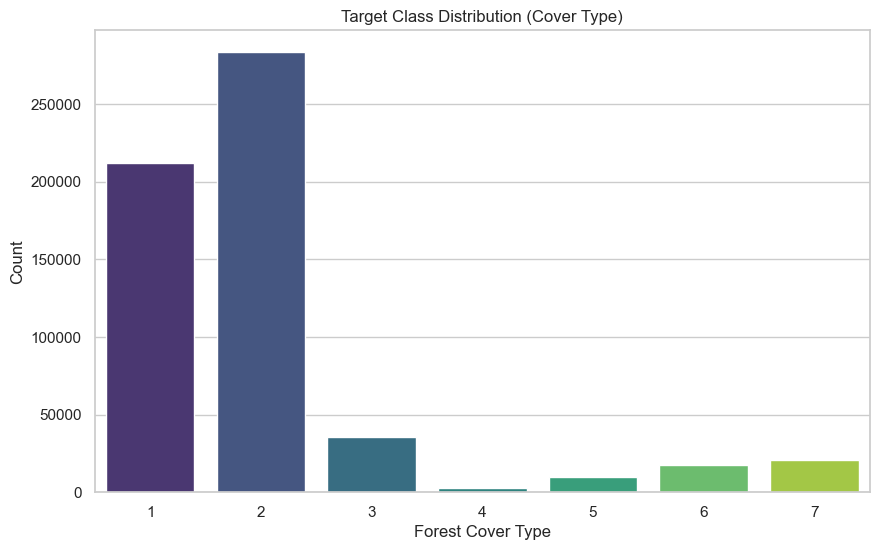

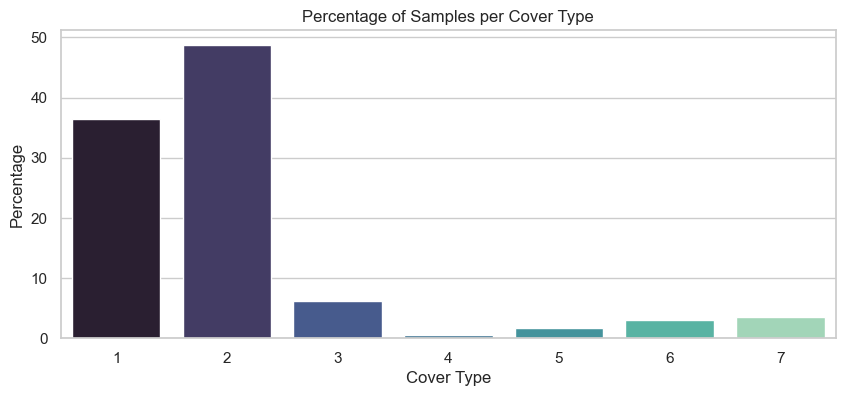

In [ ]:

print("\nTarget class distribution:")
print(df[target_col].value_counts().sort_index())

sns.countplot(data=df, x=target_col, palette="viridis")
plt.title("Target Class Distribution (Cover Type)")
plt.xlabel("Forest Cover Type")
plt.ylabel("Count")
plt.show()

class_counts = df[target_col].value_counts().sort_index()
class_percent = class_counts / len(df) * 100

plt.figure(figsize=(10, 4))
sns.barplot(x=class_counts.index, y=class_percent.values, palette="mako")
plt.title("Percentage of Samples per Cover Type")
plt.ylabel("Percentage")
plt.xlabel("Cover Type")
plt.show()

## Descriptive statistics

In [10]:
# Exclude boolean Soil_Type columns from descriptive statistics
non_soil_columns = [col for col in df.columns if not col.startswith('Soil_Type')]

print("\nDescriptive Statistics (excluding Soil_TypeX columns):")
print(df[non_soil_columns].describe())


Descriptive Statistics (excluding Soil_TypeX columns):
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     581012.000000                   581012.000000   
mean                         269.428217                       46.418855   
std                          212.549356                       58.295232   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%    

In [22]:
# --- Soil_Type Analysis ---
soil_type_cols = [col for col in binary_cols if col.startswith('Soil_Type')]

# Frequency of each Soil_Type
soil_type_freq = df[soil_type_cols].sum().sort_values(ascending=False) / len(df)
print("🟫 Relative frequency of each Soil_Type:")
print(soil_type_freq)

# Mutual exclusivity check
soil_type_sum = df[soil_type_cols].sum(axis=1)
non_exclusive_soil = (soil_type_sum != 1).sum()
if non_exclusive_soil == 0:
    print("✅ Soil_Type columns are mutually exclusive (exactly one per row).")
else:
    print(f"⚠️ {non_exclusive_soil} rows violate Soil_Type mutual exclusivity.")

print("\n" + "-"*60 + "\n")

# --- Wilderness_Area Analysis ---
wilderness_cols = [col for col in binary_cols if col.startswith('Wilderness_Area')]

# Frequency of each Wilderness_Area
wilderness_freq = df[wilderness_cols].sum().sort_values(ascending=False) / len(df)
print("🌲 Relative frequency of each Wilderness_Area:")
print(wilderness_freq)

# Mutual exclusivity check
wilderness_sum = df[wilderness_cols].sum(axis=1)
non_exclusive_wilderness = (wilderness_sum != 1).sum()
if non_exclusive_wilderness == 0:
    print("✅ Wilderness_Area columns are mutually exclusive (exactly one per row).")
else:
    print(f"⚠️ {non_exclusive_wilderness} rows violate Wilderness_Area mutual exclusivity.")

🟫 Relative frequency of each Soil_Type:
Soil_Type29    0.198356
Soil_Type23    0.099399
Soil_Type32    0.090392
Soil_Type33    0.077716
Soil_Type22    0.057439
Soil_Type10    0.056168
Soil_Type30    0.051927
Soil_Type12    0.051584
Soil_Type31    0.044175
Soil_Type24    0.036622
Soil_Type13    0.030001
Soil_Type38    0.026803
Soil_Type39    0.023762
Soil_Type11    0.021359
Soil_Type4     0.021335
Soil_Type20    0.015936
Soil_Type40    0.015060
Soil_Type2     0.012952
Soil_Type6     0.011316
Soil_Type3     0.008301
Soil_Type19    0.006921
Soil_Type17    0.005890
Soil_Type1     0.005217
Soil_Type16    0.004897
Soil_Type26    0.004456
Soil_Type18    0.003268
Soil_Type35    0.003255
Soil_Type34    0.002773
Soil_Type5     0.002749
Soil_Type9     0.001974
Soil_Type27    0.001869
Soil_Type28    0.001628
Soil_Type21    0.001442
Soil_Type14    0.001031
Soil_Type25    0.000816
Soil_Type37    0.000513
Soil_Type8     0.000308
Soil_Type36    0.000205
Soil_Type7     0.000181
Soil_Type15    0.000005


## Feature Relationship Analysis


The correlation matrix shows that most quantitative features exhibit weak to moderate linear relationships with one another. Notably, `Hillshade_9am` and `Hillshade_3pm` are strongly correlated, likely due to similar terrain shading behavior throughout the day. Other features such as `Aspect` and `Slope` show little linear correlation with the rest of the dataset, suggesting they may capture more independent or nonlinear patterns.

The mutual information matrix complements this by revealing **nonlinear dependencies** not captured by correlation. For example, `Hillshade_9am`, `Hillshade_Noon`, and `Aspect` display higher mutual information with other features, highlighting their potential relevance in models capable of learning nonlinear interactions (e.g., tree-based models or ensemble methods).

### Correlation matrix

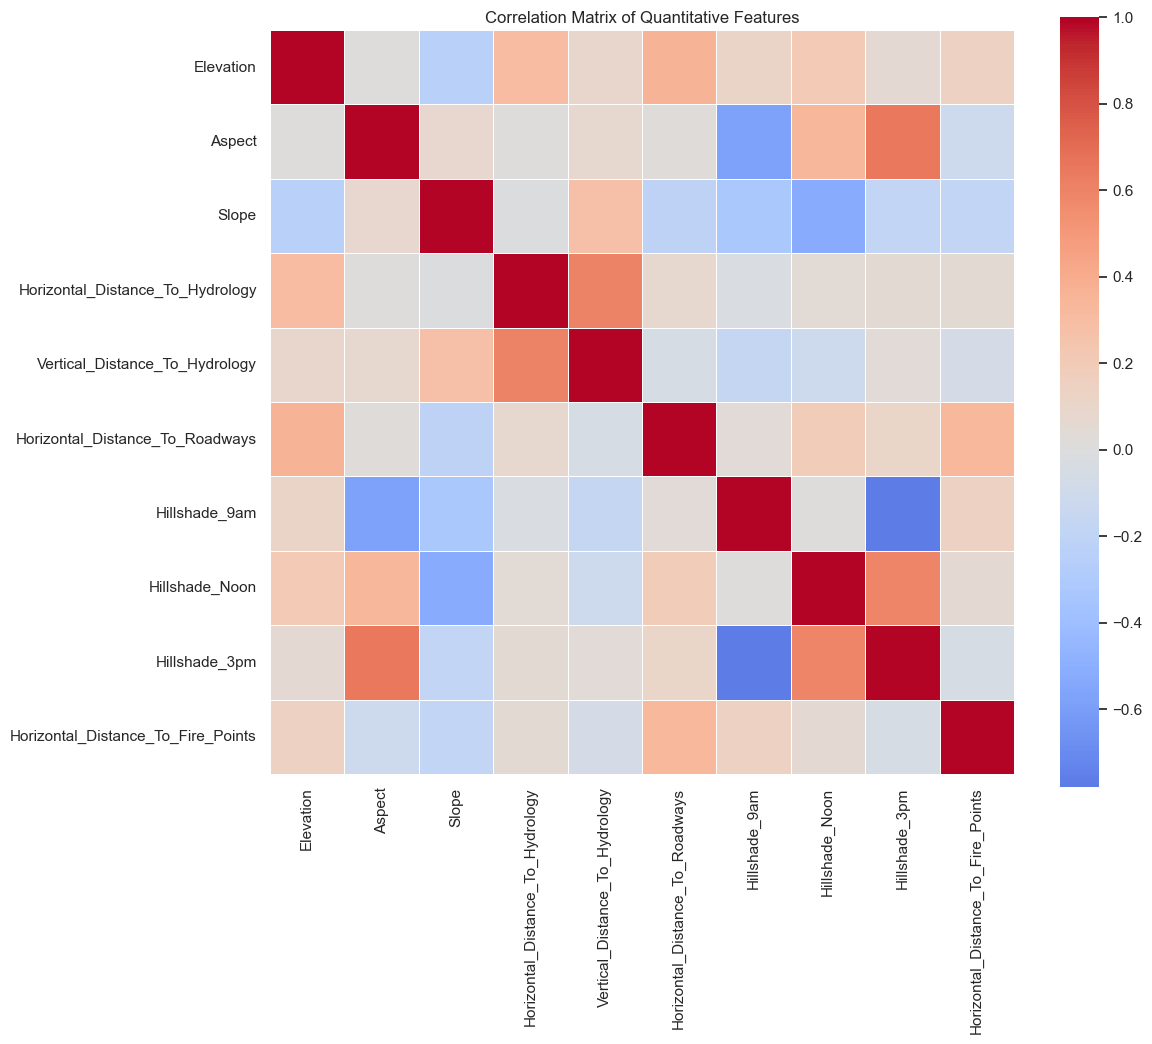

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for quantitative features
corr = df[quantitative_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.5, annot=False)
plt.title("Correlation Matrix of Quantitative Features")
plt.show()


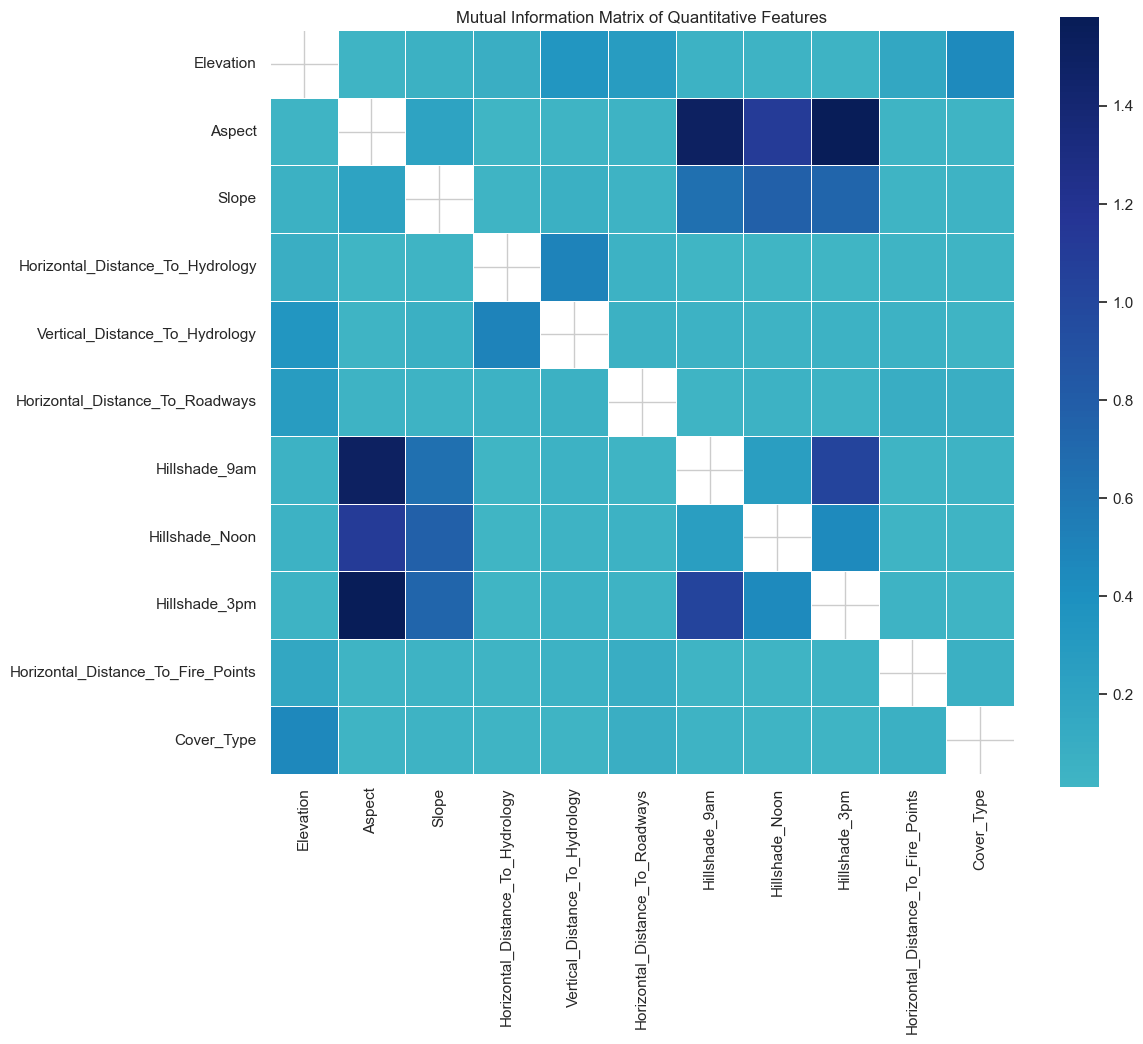

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mutual information between all pairs (MI is not symmetric like correlation, so we fake a matrix)
mi_matrix = pd.DataFrame(index=quantitative_cols, columns=quantitative_cols)

for col_x in quantitative_cols:
    X = df[quantitative_cols].copy()
    y = df[col_x]
    X = X.drop(columns=[col_x])
    
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)
    
    for i, col_y in enumerate(X.columns):
        mi_matrix.loc[col_x, col_y] = mi[i]

# Convert to float for plotting
mi_matrix = mi_matrix.astype(float)

# Fill diagonal with NaN (or 0, but MI with self is not informative)
np.fill_diagonal(mi_matrix.values, np.nan)

# Plot the mutual information heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(mi_matrix, cmap="YlGnBu", linewidths=0.5, square=True, center=0, annot=False)
plt.title("Mutual Information Matrix of Quantitative Features")
plt.show()

## 📊 Feature Distribution by Cover Type


To understand how the quantitative features relate to forest cover types, we analyzed their distributions across the seven `Cover_Type` classes using both **density plots** and **boxplots**.

#### 🔹 Key Observations:

- **Elevation** shows the strongest class-wise separation. For example, Class 1 and Class 7 appear at the highest elevations, while Classes 3 and 4 are concentrated at lower altitudes.
- **Aspect** (terrain orientation) and **Slope** show more overlapping distributions across classes, with no strong class-level separation, although slight tendencies exist (e.g., Class 4 has more concentrated aspect values).
- **Horizontal and Vertical Distance to Hydrology** both show long-tailed distributions. Though overlapping, some classes (like Class 4 and 7) are slightly shifted, indicating mild differences in terrain proximity to water sources.
- **Hillshade features (9am, Noon, 3pm)** provide some separation — especially `Hillshade_9am`, where Class 6 appears distinct.
- **Horizontal Distance to Roadways and Fire Points** show class-specific clusters, with Class 2 and 7 having broader or more distant ranges, possibly reflecting different land use or accessibility.
  
#### 🧠 Summary:
While some features (like `Elevation`) offer strong discriminatory power between classes, others (e.g., `Aspect`, `Slope`) may contribute more subtly. This analysis reinforces the value of multivariate models, as no single feature cleanly separates all cover types.

### Soil and Wilderness Area Influence on Cover Type

The heatmaps below illustrate how the binary-encoded `Soil_Type` and `Wilderness_Area` features are distributed across the seven `Cover_Type` classes. Each cell represents the **fraction of samples** in a given class for which a particular binary variable is active (value = 1).

#### 🔹 Soil_Type Distribution
- Most soil types are **strongly associated with specific forest cover types**.
- For example:
  - `Soil_Type10` is highly concentrated in Cover Type 6.
  - `Soil_Type29` and `Soil_Type27` are common in Types 2 and 3.
  - `Soil_Type23` appears primarily in Type 4.
- Many soil types are sparsely used or class-specific, indicating **strong categorical predictive value**.

#### 🔸 Wilderness_Area Distribution
- The four wilderness areas are **mutually exclusive** and show sharp class-specific patterns:
  - `Wilderness_Area1` is most frequent in Types 1 and 2.
  - `Wilderness_Area3` dominates Cover Types 5, 6, and 7.
  - `Wilderness_Area4` is **exclusively active in Types 3–6**, and makes up 100% of Type 4.
- These patterns suggest that **land zoning or regional boundaries** correlate strongly with forest type labels.

### ✅ Summary
Both `Soil_Type` and `Wilderness_Area` features carry **substantial discriminative power**. Their sparsity and sharp associations with certain `Cover_Type` values make them especially well-suited for **tree-based models** or any classifier that handles categorical features effectively.

/var/folders/_9/ljpgg9xj39790jrnflhrrl6c0000gn/T/ipykernel_87277/3200272284.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


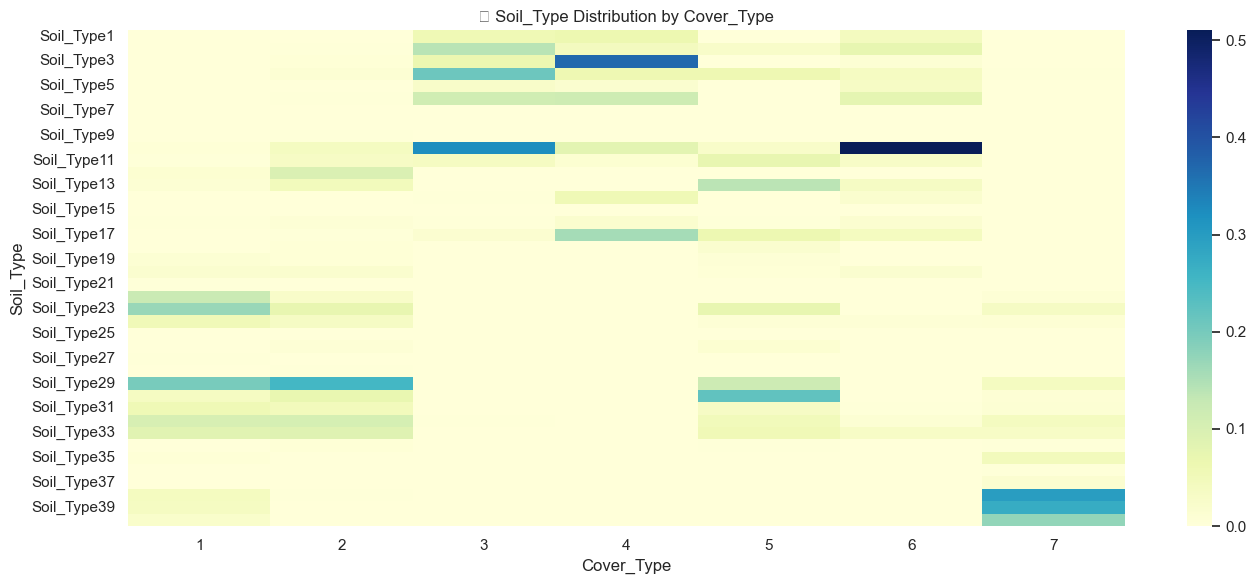

/var/folders/_9/ljpgg9xj39790jrnflhrrl6c0000gn/T/ipykernel_87277/3200272284.py:28: UserWarning: Glyph 127966 (\N{NATIONAL PARK}) missing from current font.
  plt.tight_layout()
/var/folders/_9/ljpgg9xj39790jrnflhrrl6c0000gn/T/ipykernel_87277/3200272284.py:28: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127966 (\N{NATIONAL PARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


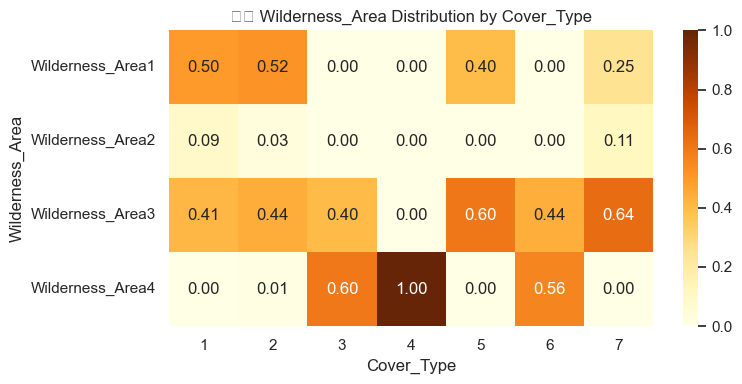

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select binary columns
soil_cols = [col for col in df.columns if col.startswith("Soil_Type")]
wilderness_cols = [col for col in df.columns if col.startswith("Wilderness_Area")]

# Grouped frequency by Cover_Type (mean of 0/1 indicates percentage of rows in each group)
soil_distribution = df.groupby("Cover_Type")[soil_cols].mean()
wilderness_distribution = df.groupby("Cover_Type")[wilderness_cols].mean()

# Plotting heatmap for Soil_Type
plt.figure(figsize=(14, 6))
sns.heatmap(soil_distribution.T, cmap="YlGnBu", annot=False, cbar=True)
plt.title("📊 Soil_Type Distribution by Cover_Type")
plt.xlabel("Cover_Type")
plt.ylabel("Soil_Type")
plt.tight_layout()
plt.show()

# Plotting heatmap for Wilderness_Area
plt.figure(figsize=(8, 4))
sns.heatmap(wilderness_distribution.T, cmap="YlOrBr", annot=True, fmt=".2f", cbar=True)
plt.title("🏞️ Wilderness_Area Distribution by Cover_Type")
plt.xlabel("Cover_Type")
plt.ylabel("Wilderness_Area")
plt.tight_layout()
plt.show()

### Distributions of quantitative features

/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/s

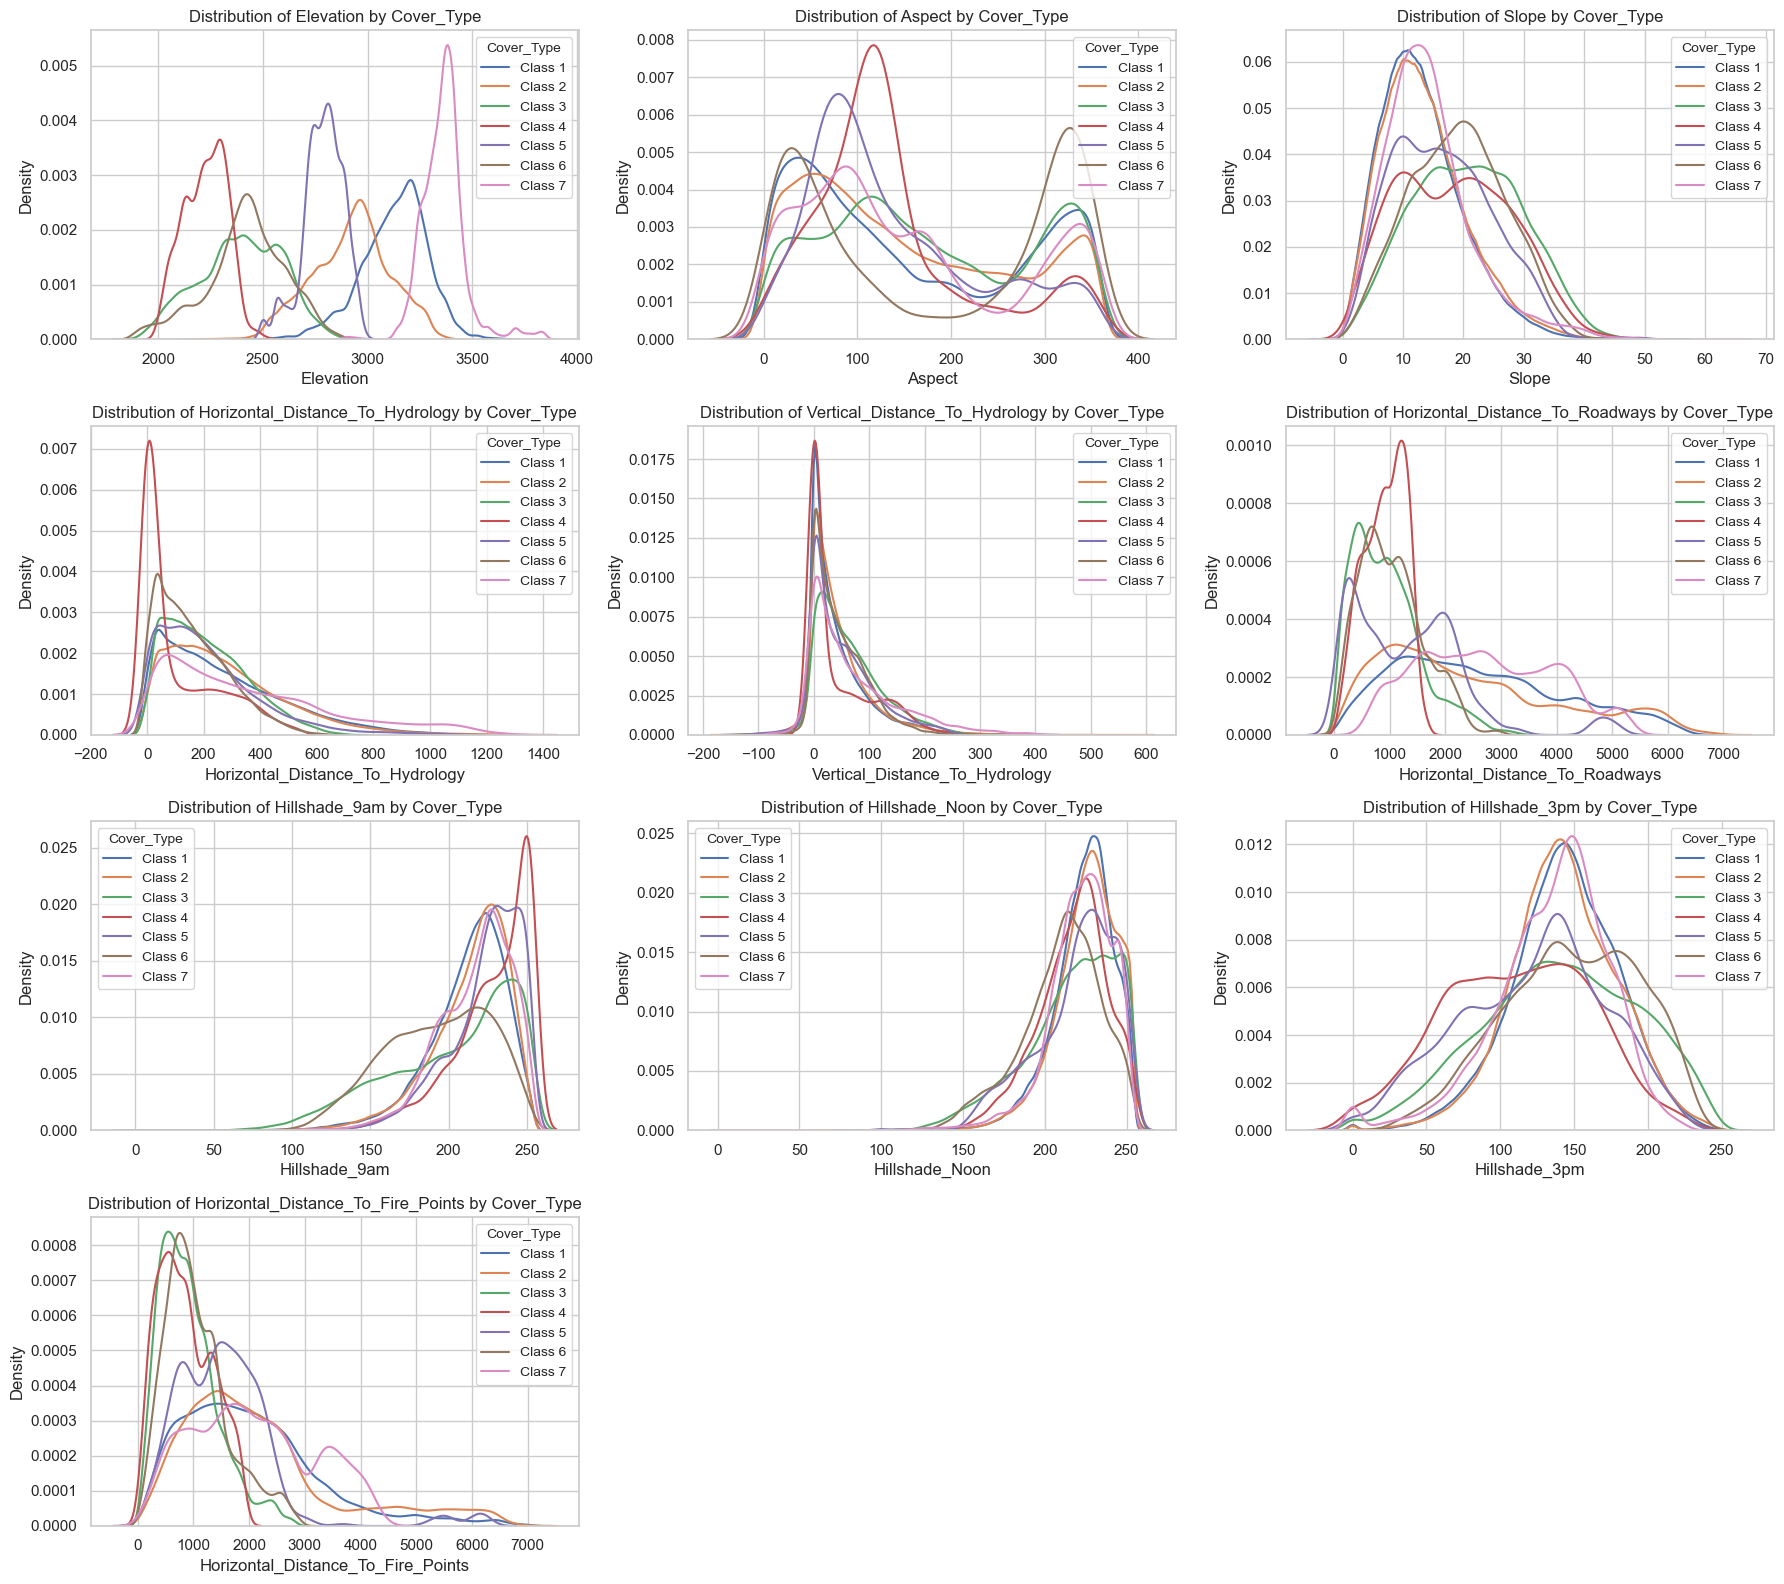

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define number of classes
class_labels = sorted(df['Cover_Type'].unique())

# Set up plot grid
num_cols = 3
num_rows = int(np.ceil(len(quantitative_cols) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
axes = axes.flatten()

# Plot KDEs for each class
for i, col in enumerate(quantitative_cols):
    for cls in class_labels:
        subset = df[df['Cover_Type'] == cls]
        sns.kdeplot(subset[col], ax=axes[i], label=f"Class {cls}", linewidth=1.5)
    
    axes[i].set_title(f"Distribution of {col} by Cover_Type")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")
    axes[i].legend(title="Cover_Type", fontsize='small', title_fontsize='small')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Boxplots to detect outlier in key feature

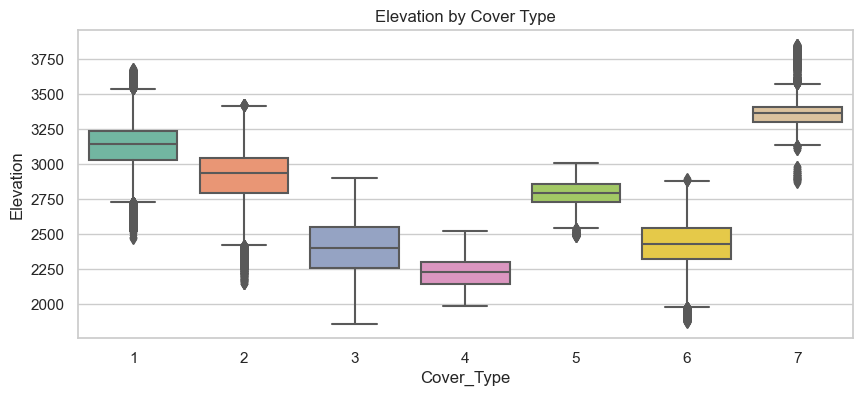

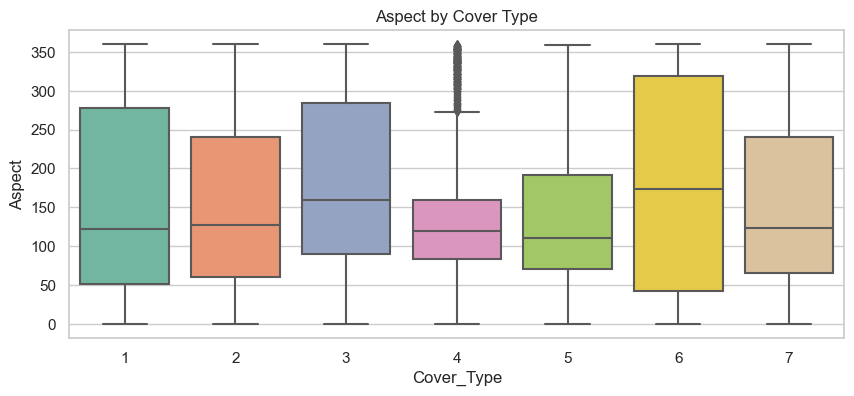

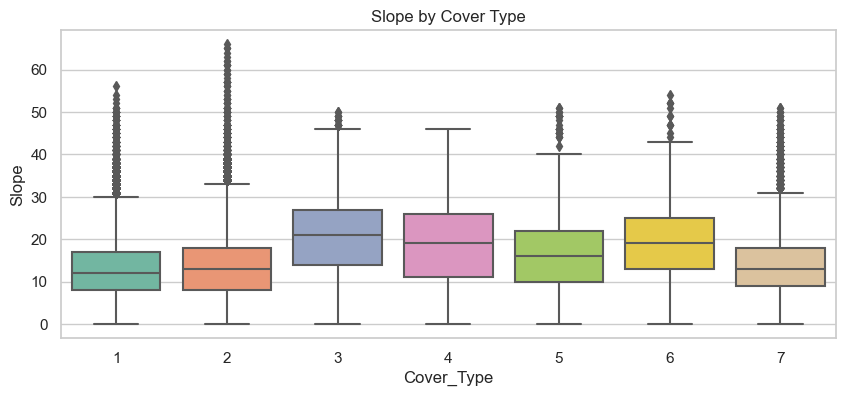

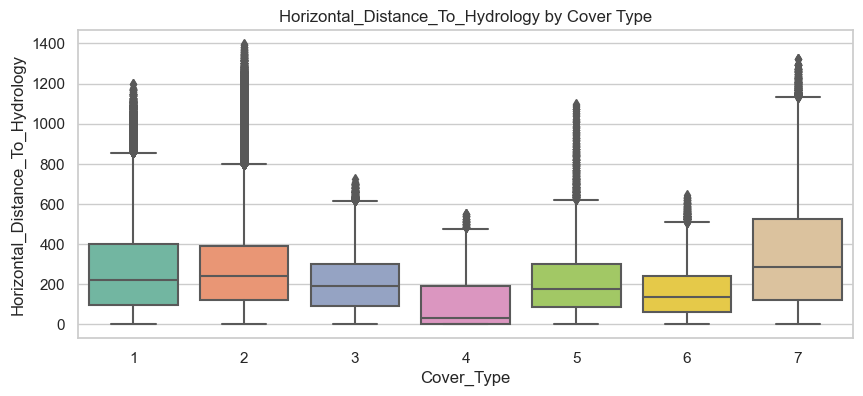

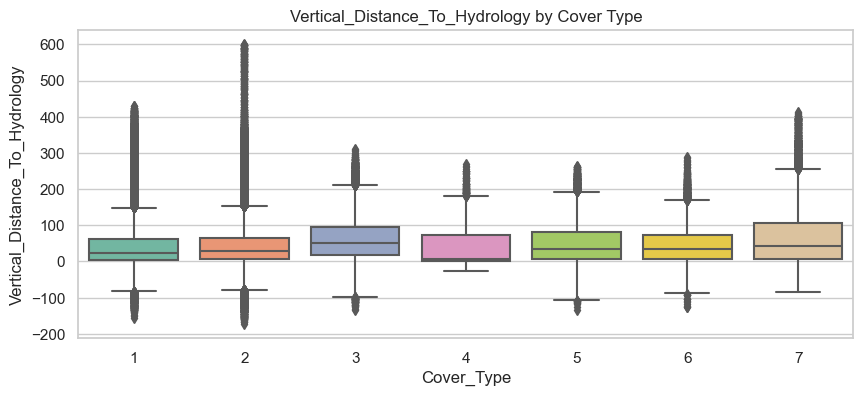

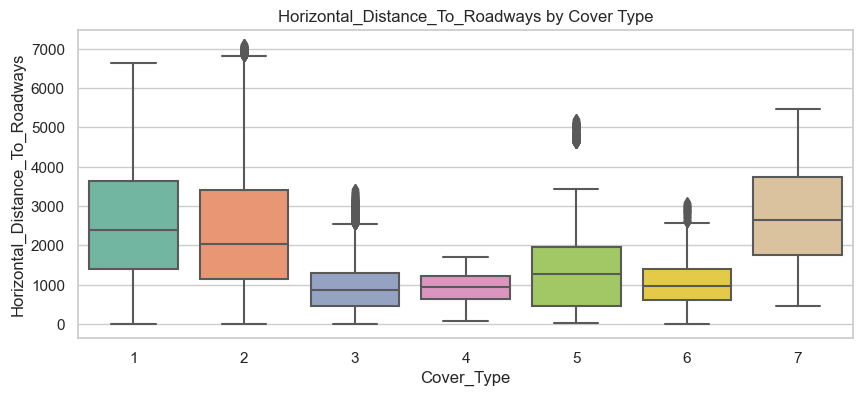

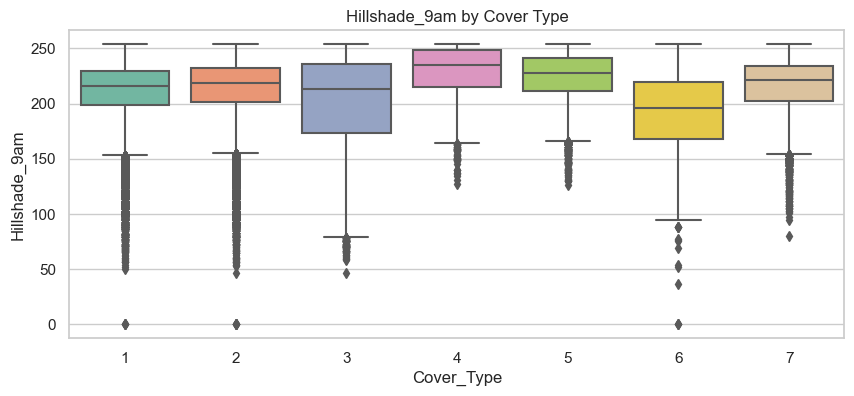

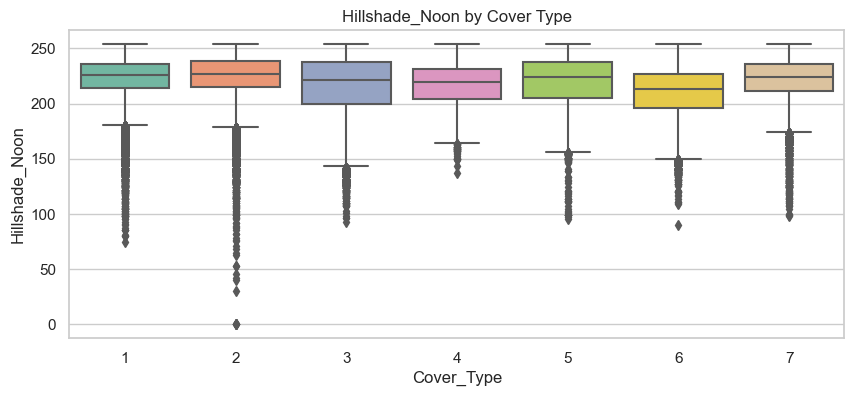

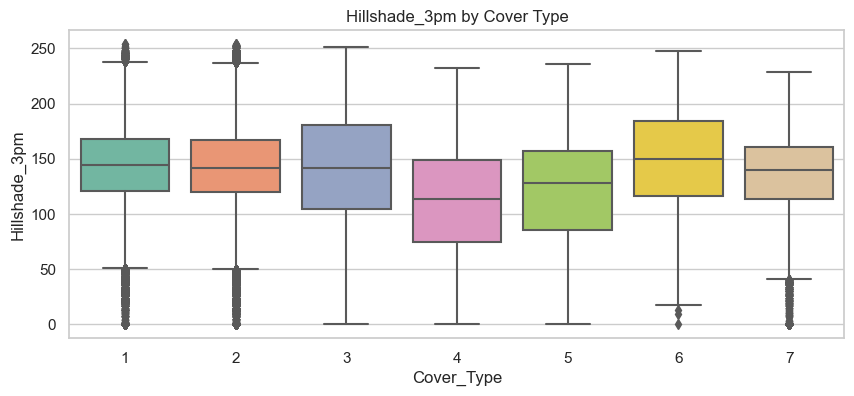

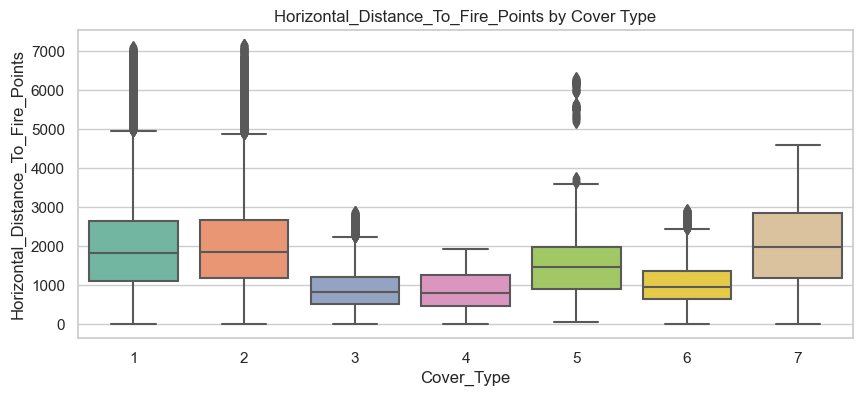

In [32]:
for col in quantitative_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=target_col, y=col, data=df, palette="Set2")
    plt.title(f"{col} by Cover Type")
    plt.show()

## Data visualizazion trough dimensionality reduction


### 🌐 Dimensionality Reduction: PCA, t-SNE, and UMAP

To explore the structure of the dataset in a lower-dimensional space, three dimensionality reduction techniques were applied to the quantitative features:

#### 🔹 PCA (Principal Component Analysis)
The PCA plot shows a smooth, continuous manifold, indicating that PCA captures some global structure. However, the class separation is minimal—most `Cover_Type` classes heavily overlap, suggesting that **PCA is not effective** at revealing distinct clusters in this dataset.

#### 🔹 t-SNE (t-Distributed Stochastic Neighbor Embedding)
t-SNE produces well-separated clusters with clearly defined local groupings. This suggests that t-SNE is effective at preserving **local structure** and highlights potential nonlinear separability between some forest cover types. However, t-SNE does not preserve global distances, so inter-cluster positioning is not meaningful.

#### 🔹 UMAP (Uniform Manifold Approximation and Projection)
UMAP also reveals strong cluster separation and preserves both local and partial global structure. Classes 3 and 4, for example, form distinct, dense regions. UMAP provides a more interpretable global view compared to t-SNE.



### PCA

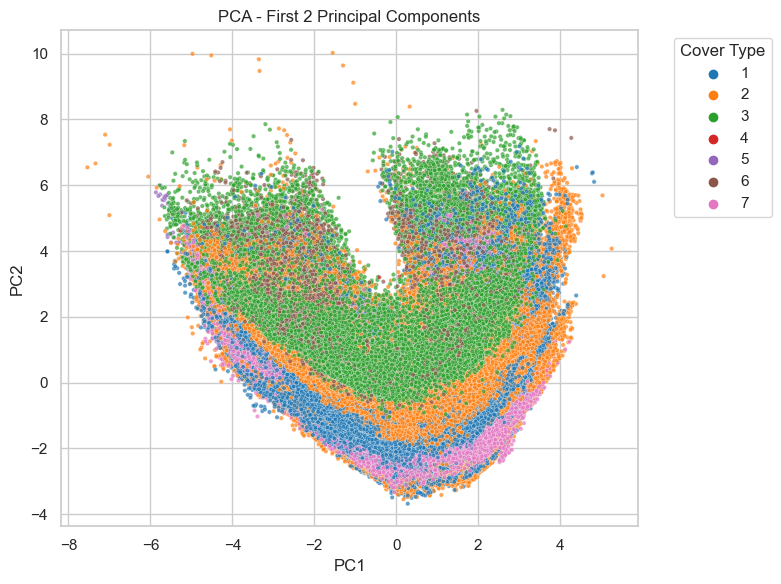

In [ ]:
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(df[quantitative_cols])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df[target_col], palette="tab10", s=10, alpha=0.7)
plt.title("PCA - First 2 Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### t-SNE

/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


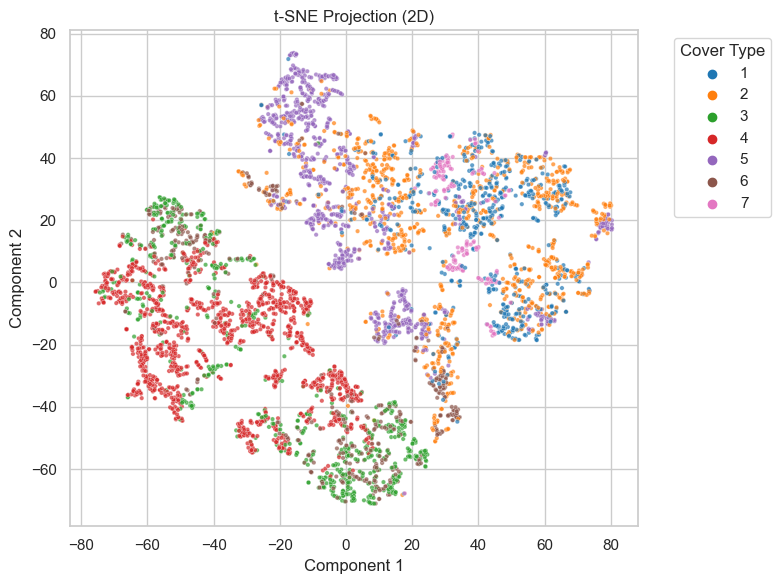

In [34]:
from sklearn.manifold import TSNE

# Use fewer samples for performance if dataset is large
X_sample = X_scaled[:5000]
y_sample = df[target_col].iloc[:5000]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sample, palette="tab10", s=10, alpha=0.7)
plt.title("t-SNE Projection (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### UMAP

/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


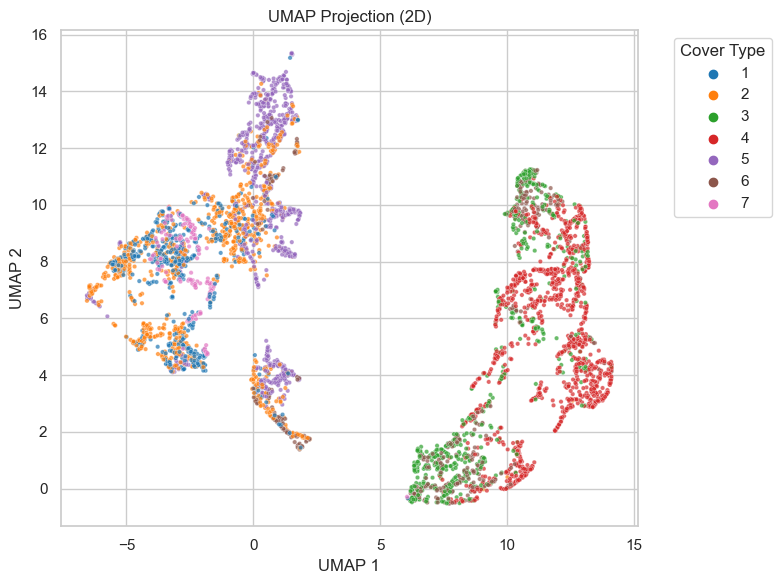

In [35]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled[:5000])
y_umap = df["Cover_Type"].iloc[:5000]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_umap, palette="tab10", s=10, alpha=0.7)
plt.title("UMAP Projection (2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Classifiers

### 🧠 Model Selection Justification

This dataset exhibits several characteristics that directly influence model effectiveness:

- **Mixed data types**: It contains both **continuous features** (e.g., Elevation, Slope, Hillshade) and **high-dimensional binary features** (e.g., `Soil_TypeX`, `Wilderness_AreaX`).
- **High cardinality in binary features**: The presence of 40 soil types benefits models that can handle **sparse, one-hot encoded inputs** effectively.
- **Nonlinear relationships**: Variables such as `Elevation`, `Hillshade`, and `Distance to Hydrology` are likely to influence the target in a nonlinear fashion.
- **Multiclass classification**: The target has **seven distinct forest cover types**, requiring models that support multiclass classification and can balance class-specific performance.
- **Slight class imbalance**: Some classes appear more frequently than others, making metrics like **recall** and **G-Mean** important for evaluation.

Given these properties, the following model types are most appropriate:

#### ✅ Recommended:
- **Tree-based models** (e.g., Random Forest, XGBoost): These models naturally handle mixed feature types, model nonlinear relationships, and are robust to class imbalance.
- **K-Nearest Neighbors**: Performs reasonably well due to sensitivity to local feature patterns, though scalability may be a limitation for larger datasets.

#### ⚠️ Less Suitable:
- **Linear models** (e.g., Logistic Regression, Linear SVM): These are useful as interpretable baselines but often fail to capture the complexity of nonlinear, high-dimensional relationships.
- **Naive Bayes**: Assumes independence among features, which is unrealistic in this dataset given environmental and spatial dependencies.
- **Kernel-based SVMs**: Their high computational cost and poor performance in this case make them impractical without advanced tuning or dimensionality reduction.

---

### 📊 Model Performance Comparison and Insights

The table below compares the performance of multiple ML models using several evaluation metrics: **Accuracy**, **F1 Score**, **G-Mean**, **Recall**, and **Specificity**. This helps assess both overall and per-class model behavior.

#### 🔹 Top Performing Models:
- **Random Forest** (both standard and balanced variants) leads in every metric, with over **95% accuracy and F1**, and excellent per-class balance.
- **K-Nearest Neighbors** also performs strongly, achieving above **92% accuracy** and solid G-Mean and recall.
- **XGBoost**, while slightly lower in raw accuracy (~87%), maintains **strong class balance**, with high G-Mean and decent recall.

#### 🔸 Moderate Models:
- **Logistic Regression** and **Linear SVMs** perform acceptably but struggle with **recall and G-Mean**, suggesting weaker performance on minority classes.
- **Balanced variants** of these models help boost recall but typically reduce precision and overall F1.

#### 🔻 Weak Performers:
- **Standard and balanced SVM (non-linear kernels)** and **Naive Bayes** perform poorly, with very low F1 and G-Mean scores. This reflects their inability to manage the complexity and dimensionality of the dataset without significant preprocessing.

#### 📝 Additional Observations:
- The **use of class weighting (balanced versions)** had mixed effects. While it improved recall in underrepresented classes, it often **reduced overall accuracy and F1**, especially in models like SVM.

---

### ✅ Conclusion

Given the structure of the dataset, **Random Forest** and **XGBoost** are the most effective models — they handle the mix of continuous and binary features well, require minimal preprocessing, and yield high and balanced performance. Simpler models are useful for interpretability or benchmarking but are not suitable for production-level performance in this case.

### Train-test split

In [42]:
X_quant = df[quantitative_cols]
X_binary = df[binary_cols]
y = df[target_col] - 1  # Convert labels from 1–7 to 0–6

# Train-test split
X_train_q, X_test_q, X_train_bin, X_test_bin, y_train, y_test = train_test_split(
    X_quant, X_binary, y, test_size=0.2, random_state=42, stratify=y
)

### Feature scaling

In [43]:
# Scale only the quantitative features
scaler = StandardScaler()
X_train_q_scaled = scaler.fit_transform(X_train_q)
X_test_q_scaled = scaler.transform(X_test_q)

# Concatenate scaled quantitative with binary features
from numpy import hstack
X_train = np.hstack([X_train_q_scaled, X_train_bin])
X_test = np.hstack([X_test_q_scaled, X_test_bin])


### Model Definition

In [44]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Logistic Regression - Balanced": LogisticRegression(max_iter=100, class_weight='balanced'),

    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Random Forest - Balanced": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),

    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "LinearSVC": LinearSVC(max_iter=1000),
    "LinearSVC - Balanced": LinearSVC(max_iter=1000, class_weight='balanced'),

    "Support Vector Machine": SVC(max_iter=100),
    "Support Vector Machine - Balanced": SVC(max_iter=100, class_weight='balanced'),

    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
}

### Train and evaluate each model

In [45]:
# Train and evaluate
results = []

for name, model in models.items():
    print(f"\n📌 {name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)

    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    gmean = geometric_mean_score(y_test, y_pred, average='macro')

    print(classification_report(y_test, y_pred, zero_division=0))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "G-Mean": gmean,
        "Recall (macro avg)": recall.mean(),
        "Specificity (macro avg)": np.mean(specificity)
    })



📌 Logistic Regression


/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.71      0.70      0.70     42368
           1       0.75      0.80      0.77     56661
           2       0.67      0.81      0.73      7151
           3       0.59      0.38      0.46       549
           4       0.17      0.01      0.01      1899
           5       0.49      0.25      0.33      3473
           6       0.73      0.55      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.59      0.50      0.52    116203
weighted avg       0.71      0.72      0.71    116203


📌 Logistic Regression - Balanced


/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.68      0.66      0.67     42368
           1       0.79      0.52      0.62     56661
           2       0.70      0.56      0.62      7151
           3       0.29      0.89      0.44       549
           4       0.10      0.79      0.18      1899
           5       0.34      0.66      0.45      3473
           6       0.40      0.89      0.55      4102

    accuracy                           0.60    116203
   macro avg       0.47      0.71      0.51    116203
weighted avg       0.70      0.60      0.63    116203


📌 Random Forest
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     42368
           1       0.95      0.97      0.96     56661
           2       0.94      0.96      0.95      7151
           3       0.91      0.85      0.88       549
           4       0.95      0.78      0.85      1899
           5       0.93      0.89      0.91      3473
       

/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.40      0.72      0.51     42368
           1       0.55      0.22      0.31     56661
           2       0.57      0.33      0.42      7151
           3       0.20      0.48      0.29       549
           4       0.04      0.09      0.06      1899
           5       0.25      0.20      0.22      3473
           6       0.15      0.15      0.15      4102

    accuracy                           0.41    116203
   macro avg       0.31      0.31      0.28    116203
weighted avg       0.46      0.41      0.38    116203


📌 Support Vector Machine - Balanced


/Users/antoniosquicciarini/miniconda/envs/env_pytorch_new/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42368
           1       0.00      0.00      0.00     56661
           2       0.29      0.55      0.38      7151
           3       0.17      0.68      0.27       549
           4       0.03      0.70      0.05      1899
           5       0.27      0.12      0.17      3473
           6       0.09      1.00      0.16      4102

    accuracy                           0.09    116203
   macro avg       0.12      0.44      0.15    116203
weighted avg       0.03      0.09      0.04    116203


📌 Naive Bayes
              precision    recall  f1-score   support

           0       0.16      0.02      0.04     42368
           1       0.85      0.01      0.03     56661
           2       0.30      0.40      0.34      7151
           3       0.07      1.00      0.14       549
           4       0.03      0.74      0.05      1899
           5       0.17      0.08      0.11      3473
         

### Results summary

In [46]:
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\n📊 Model Performance Comparison:")
print(results_df)



📊 Model Performance Comparison:
                                Model  Accuracy  F1 Score    G-Mean  \
3            Random Forest - Balanced  0.955380  0.955163  0.947867   
2                       Random Forest  0.954063  0.953830  0.946090   
4                 K-Nearest Neighbors  0.928479  0.928285  0.919282   
10                            XGBoost  0.869607  0.869023  0.897438   
0                 Logistic Regression  0.723071  0.712942  0.682943   
5                           LinearSVC  0.711419  0.695551  0.644817   
6                LinearSVC - Balanced  0.680938  0.688286  0.761498   
1      Logistic Regression - Balanced  0.596930  0.625751  0.808567   
7              Support Vector Machine  0.405566  0.379588  0.522934   
9                         Naive Bayes  0.093216  0.061737  0.629683   
8   Support Vector Machine - Balanced  0.087390  0.036032  0.614186   

    Recall (macro avg)  Specificity (macro avg)  
3             0.908252                 0.989211  
2             

### Visualize model performance

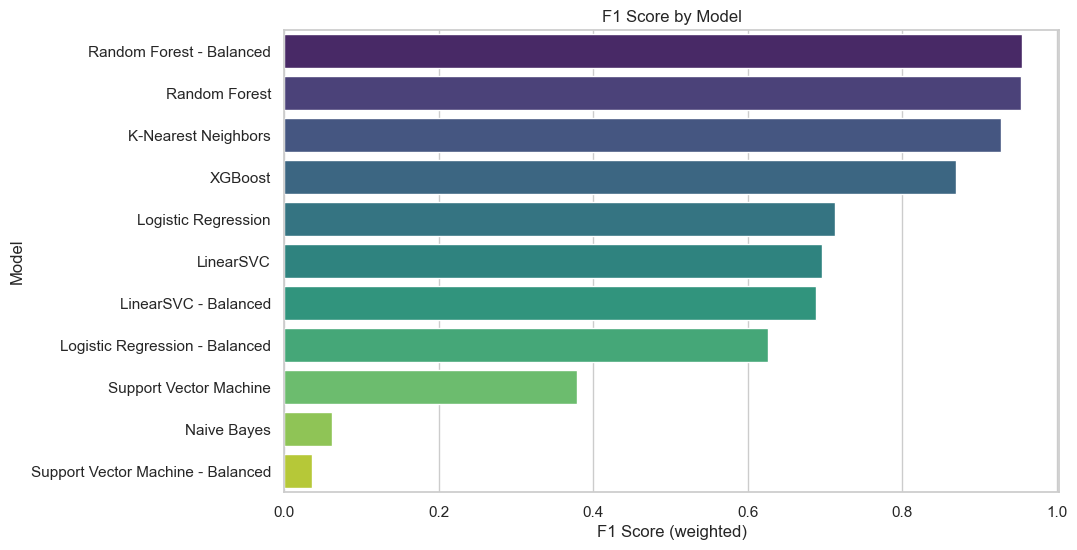

In [47]:
sns.barplot(data=results_df, x="F1 Score", y="Model", palette="viridis")
plt.title("F1 Score by Model")
plt.xlabel("F1 Score (weighted)")
plt.ylabel("Model")
plt.show()